In [2]:
%pylab inline
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp

Populating the interactive namespace from numpy and matplotlib


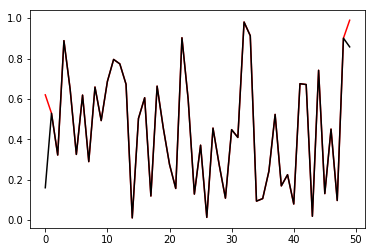

In [19]:
p=rand(50)
plot(p,c="r")
plot(abs(fft.rfft(fft.irfft(p*exp(2j*pi*rand(50)*concatenate(([1],ones(48),[1])))))),c="k")

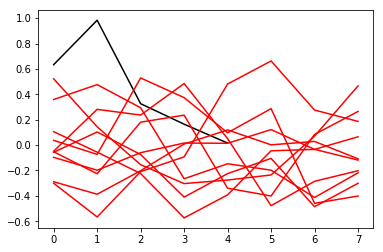

In [2]:
# Array size for power spectrum. field size is 2*(size-1)
size=5
input_size=2*(size-1)

# Define input function for estimator
batch_size = 256

#Number of samples to learn each power spectrum
sample_size=32

# Number of training and testing simulations
nsims_train = 100000
nsims_test = 10000

# Each P(k) samples from the prior U[0,1]
p_train = rand(nsims_train,1,size)
p_test = rand(nsims_test,1,size)

x_train = fft.irfft(sqrt(p_train)*randn(nsims_train,sample_size,size)*
                    exp(2j*pi*concatenate((zeros((nsims_train,sample_size,1)),rand(nsims_train,sample_size,size-2),zeros((nsims_train,sample_size,1))),axis=-1)))
x_test = fft.irfft(sqrt(p_test)*randn(nsims_test,sample_size,size)*
                   exp(2j*pi*concatenate((zeros((nsims_test,sample_size,1)),rand(nsims_test,sample_size,size-2),zeros((nsims_test,sample_size,1))),axis=-1)))

plot(p_train[0,0],c="k")
for i in range(10):
    plot(x_train[0,i],c="r") 

def _prior_sampling_input_fn():
    """Serving input fn for training data"""
    dataset = tf.data.Dataset.from_tensor_slices((x_train.astype('float32'), p_train.astype('float32')))
    dataset = dataset.repeat().shuffle(1000).batch(batch_size//sample_size)
    return dataset

def _testing_input_fn():
    """Serving input fn for testing data"""
    dataset = tf.data.Dataset.from_tensor_slices((x_test.astype('float32'), p_test.astype('float32')))
    dataset = dataset.batch(batch_size//sample_size)
    return dataset

In [3]:
def build_model_keras():
    model = keras.Sequential([
        keras.layers.Dense(4*size, activation=tf.nn.tanh,
                           input_shape=(sample_size,input_size,)),
        keras.layers.Dense(16*size, activation=tf.nn.tanh),
        keras.layers.Dense(4*size, activation=tf.nn.tanh),
        keras.layers.Dense(size, activation=tf.nn.tanh),
        keras.layers.GlobalAveragePooling1D()
    ])
    model.compile(loss='mse',
                optimizer='sgd')
    return model

simple_model = build_model_keras()
simple_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32, 20)            180       
_________________________________________________________________
dense_1 (Dense)              (None, 32, 80)            1680      
_________________________________________________________________
dense_2 (Dense)              (None, 32, 20)            1620      
_________________________________________________________________
dense_3 (Dense)              (None, 32, 5)             105       
_________________________________________________________________
global_average_pooling1d (Gl (None, 5)                 0         
Total params: 3,585
Trainable params: 3,585
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Store training stats
history = simple_model.fit(x_train, p_train[:,0,:], epochs=500,
                    validation_split=0.2, verbose=1,
                    callbacks=[early_stop,PrintDot()])

Train on 80000 samples, validate on 20000 samples
Epoch 1/500
80000/80000 [==============================] - 7s 87us/step - loss: 0.0836 - val_loss: 0.0835
Epoch 2/500
80000/80000 [==============================] - 7s 87us/step - loss: 0.0834 - val_loss: 0.0833
Epoch 3/500
80000/80000 [==============================] - 7s 85us/step - loss: 0.0833 - val_loss: 0.0833
Epoch 4/500
80000/80000 [==============================] - 7s 86us/step - loss: 0.0832 - val_loss: 0.0832
Epoch 5/500
80000/80000 [==============================] - 7s 88us/step - loss: 0.0831 - val_loss: 0.0831
Epoch 6/500
80000/80000 [==============================] - 7s 85us/step - loss: 0.0831 - val_loss: 0.0830
Epoch 7/500
80000/80000 [==============================] - 7s 85us/step - loss: 0.0830 - val_loss: 0.0829
Epoch 8/500
80000/80000 [==============================] - 7s 86us/step - loss: 0.0829 - val_loss: 0.0828
Epoch 9/500
80000/80000 [==============================] - 7s 88us/step - loss: 0.0828 - val_loss: 0.0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



80000/80000 [==============================] - 7s 85us/step - loss: 0.0284 - val_loss: 0.0283
Epoch 167/500
80000/80000 [==============================] - 7s 85us/step - loss: 0.0284 - val_loss: 0.0283
Epoch 168/500
80000/80000 [==============================] - 7s 86us/step - loss: 0.0283 - val_loss: 0.0282
Epoch 169/500
80000/80000 [==============================] - 7s 88us/step - loss: 0.0283 - val_loss: 0.0282
Epoch 170/500
80000/80000 [==============================] - 7s 85us/step - loss: 0.0283 - val_loss: 0.0282
Epoch 171/500
80000/80000 [==============================] - 7s 85us/step - loss: 0.0283 - val_loss: 0.0282
Epoch 172/500
80000/80000 [==============================] - 7s 85us/step - loss: 0.0282 - val_loss: 0.0281
Epoch 173/500
80000/80000 [==============================] - 7s 85us/step - loss: 0.0282 - val_loss: 0.0281
Epoch 174/500
80000/80000 [==============================] - 7s 85us/step - loss: 0.0282 - val_loss: 0.0281
Epoch 175/500
80000/80000 [===============

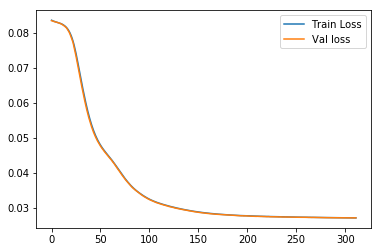

In [6]:
plot(history.epoch, array(history.history['loss']),
           label='Train Loss')
plot(history.epoch, array(history.history['val_loss']),
           label = 'Val loss')
legend()

In [8]:
train_pred=simple_model.predict(x_train)
test_pred=simple_model.predict(x_test)

In [9]:
mean((train_pred-p_train[:,0,:])**2),mean((test_pred-p_test[:,0,:])**2)

(0.02717117026500021, 0.02715889648831996)

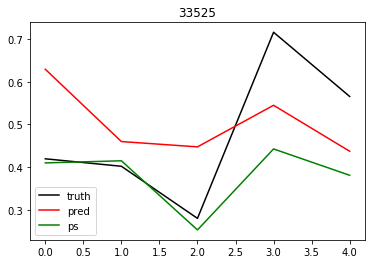

In [19]:
i=randint(nsims_train)
plot(p_train[i,0],c="k",label="truth")
plot(train_pred[i],c="r",label="pred")
plot(mean(abs(fft.rfft(x_train[i]))**2,axis=0),c="g",label="ps")
title(i)
legend()

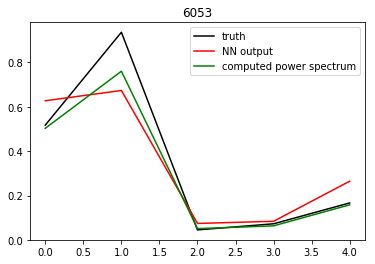

In [22]:
i=randint(nsims_test)
plot(p_test[i,0],c="k",label="truth")
plot(test_pred[i],c="r",label="NN output")
plot(mean(abs(fft.rfft(x_test[i]))**2,axis=0),c="g",label="computed power spectrum")
title(i)
legend()

$y=x^2$, $x$ is Gaussianly distributed.
$$\rho(y)=\left.\rho(x)\frac{dx}{dy}\right|_{x=\pm\sqrt{y}}=2\frac{e^{-\frac{x^2}{2 P}}}{\sqrt{2\pi P}}\frac{1}{2x}=\frac{e^{-\frac{y}{2 P}}}{\sqrt{2\pi P y}}$$
$\langle y\rangle = P$, and $\langle y^2\rangle=3P^2$.
$P$ is uniformly distributed in $[0,1]$, so $\langle P\rangle=\frac{1}{2}$ and $\langle P^2\rangle=\frac{1}{3}$.
$$\langle (y-P)^2\rangle=\langle 2P^2\rangle=\frac{2}{3}$$
If we average over $N$ $y$ samples, then $\langle (\overline{y}-P)^2\rangle=\langle\frac{2P^2}{N}\rangle=\frac{2}{3N}$
$$F=\left\langle\frac{\partial^2\log\rho(y|P)}{\partial P^2}\right\rangle=\frac{1}{2P^2}$$

24508 4


(0, 19.8)

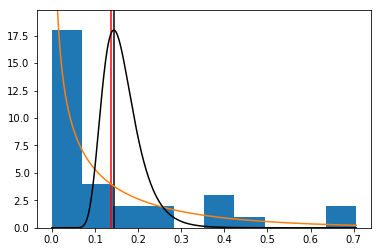

In [26]:
#mean((mean(abs(fft.rfft(x_train))**2,axis=1)-p_train)**2),
i=randint(nsims_train)
j=randint(size)
print(i,j)
count,bins,n=hist(abs(fft.rfft(x_train[i])[:,j])**2)
axvline(x=p_train[i,0,j],c="r")
axvline(x=mean(abs(fft.rfft(x_train[i])[:,j])**2),c="k")
xax=linspace(bins[0],bins[-1],1000)
plot(xax,exp(-xax/2/p_train[i,0,j])/(2*pi*p_train[i,0,j]*xax)**.5*sample_size*(bins[1]-bins[0]))
post=exp(-sum(abs(fft.rfft(x_train[i])[:,j])**2)/2/xax)/xax**(sample_size/2)
post=post*max(count)/max(post)
plot(xax,post,c="k")
ylim(0,max(count)*1.1)

/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


(0.9999999999946371, 2.0066948103192317e-11)

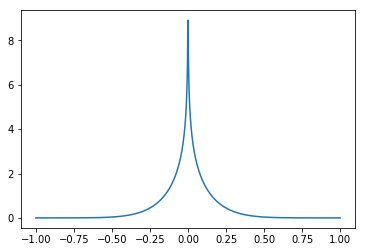

In [28]:
from scipy.integrate import quad

def err_prob(e,n=sample_size):
    gauss = lambda p: exp(-n*e**2/4/p**2)/(pi/n)**.5/p/2
    return quad(gauss,0,1)[0]

plt.plot(linspace(-1,1,1000),[err_prob(x) for x in linspace(-1,1,1000)])
quad(err_prob,-inf,inf)

265225.0 224618.0


(0.020856955889562896, 0.020833333333333332)

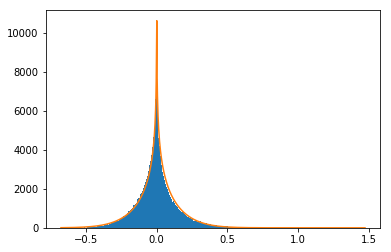

In [29]:
count,bins,n=hist((mean(abs(fft.rfft(x_train))**2,axis=1)-p_train[:,0,:]).flatten(),bins=1000)
print(sum(count[:(where(bins>0)[0][0]-1)]),sum(count[where(bins>0)[0][0]:]))
plot((bins[:-1]+bins[1:])/2,[quad(err_prob,bins[i],bins[i+1])[0]*size*nsims_train for i in range(1000)])
mean((mean(abs(fft.rfft(x_train))**2,axis=1)-p_train[:,0,:])**2),2/3/sample_size

244491.0 254311.0


(0.02717117026500021, 0.020833333333333332)

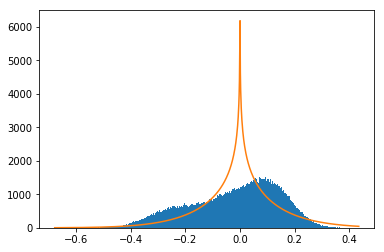

In [31]:
count,bins,n=hist((train_pred-p_train[:,0,:]).flatten(),bins=1000)
print(sum(count[:(where(bins>0)[0][0]-1)]),sum(count[where(bins>0)[0][0]:]))
plot((bins[:-1]+bins[1:])/2,[quad(err_prob,bins[i],bins[i+1])[0]*size*nsims_train for i in range(1000)])
mean((train_pred-p_train[:,0,:])**2),2/3/sample_size

26371.0 22662.0


(0.020838120396771104, 0.020833333333333332)

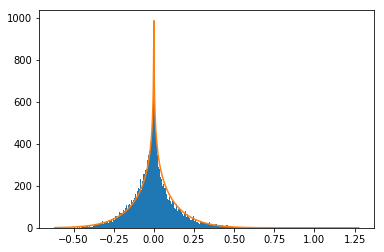

In [32]:
count,bins,n=hist((mean(abs(fft.rfft(x_test))**2,axis=1)-p_test[:,0,:]).flatten(),bins=1000)
print(sum(count[:(where(bins>0)[0][0]-1)]),sum(count[where(bins>0)[0][0]:]))
plot((bins[:-1]+bins[1:])/2,[quad(err_prob,bins[i],bins[i+1])[0]*size*nsims_test for i in range(1000)])
mean((mean(abs(fft.rfft(x_test))**2,axis=1)-p_test[:,0,:])**2),2/3/sample_size

24526.0 25370.0


(0.02715889648831996, 0.020833333333333332)

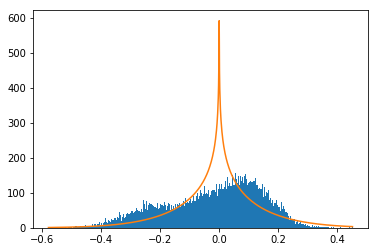

In [33]:
count,bins,n=hist((test_pred-p_test[:,0,:]).flatten(),bins=1000)
print(sum(count[:(where(bins>0)[0][0]-1)]),sum(count[where(bins>0)[0][0]:]))
plot((bins[:-1]+bins[1:])/2,[quad(err_prob,bins[i],bins[i+1])[0]*size*nsims_test for i in range(1000)])
mean((test_pred-p_test[:,0,:])**2),2/3/sample_size

1.0002471982833965 0.25019338836990423


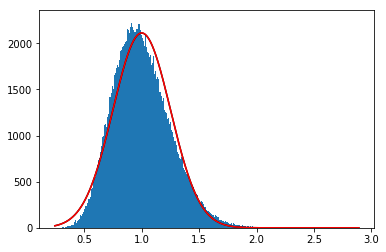

In [34]:
d=(mean(abs(fft.rfft(x_train))**2,axis=1)/p_train[:,0,:]).flatten()
count,bins,n=hist(d,bins=1000)
m,s=mean(d),std(d)
print(m,s)
x=(bins[:-1]+bins[1:])/2
plot(x,exp(-(x-m)**2/2/s**2)/s/(2*pi)**.5*nsims_train*size*(bins[1]-bins[0]),c="k")
m,s=1,(2/sample_size)**.5
plot(x,exp(-(x-m)**2/2/s**2)/s/(2*pi)**.5*nsims_train*size*(bins[1]-bins[0]),c="r")

1.0704370119552438 0.3608520079734593


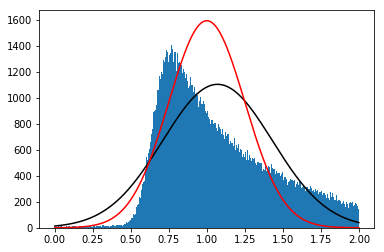

In [35]:
d=(train_pred/p_train[:,0,:]).flatten()
d=d[abs(d-1)<1]
count,bins,n=hist(d,bins=1000)
m,s=mean(d),std(d)
print(m,s)
x=(bins[:-1]+bins[1:])/2
plot(x,exp(-(x-m)**2/2/s**2)/s/(2*pi)**.5*nsims_train*size*(bins[1]-bins[0]),c="k")
m,s=1,(2/sample_size)**.5
plot(x,exp(-(x-m)**2/2/s**2)/s/(2*pi)**.5*nsims_train*size*(bins[1]-bins[0]),c="r")

1.0682568413648956 0.3603069593020798


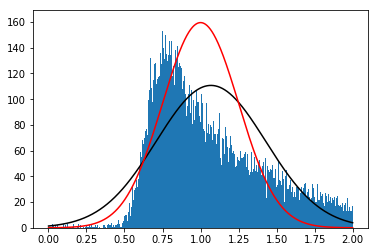

In [36]:
d=(test_pred/p_test[:,0,:]).flatten()
d=d[abs(d-1)<1]
count,bins,n=hist(d,bins=1000)
m,s=mean(d),std(d)
print(m,s)
x=(bins[:-1]+bins[1:])/2
plot(x,exp(-(x-m)**2/2/s**2)/s/(2*pi)**.5*nsims_test*size*(bins[1]-bins[0]),c="k")
m,s=1,(2/sample_size)**.5
plot(x,exp(-(x-m)**2/2/s**2)/s/(2*pi)**.5*nsims_test*size*(bins[1]-bins[0]),c="r")

Questions:
1. Zero-mean fields? For density contrast maps, zero-k mode is zero? For convergence maps? But maps are usually much smaller than the full sky?
2. Why iz not working???
3. How to estimate power spectrum for flattening? Use each map to flatten power spectrum? If we use multiple maps, it will cause correlations between data.
4. Is there a way to build semi-connected layers, or to compute a loss function that first averages the same NN over all the inputs? (this problem only exists for 1d power spectra and for low-k and high-k modes in higher dimensions due to rotational invariance)
5. For 2d, how to specify power spectrum? Pixels mostly have slightly different values of k (usually 8 copies of same value). Is P(k) a function that is only evaluated at certai points? (We could try e.g. a degree n polynomial and try to train n+1 nuerons as a summary statistic.) How do we know it is continuous on these scales? 
6. What scales are we looking at? Does the lensing model account for the difference in time between different points on the los integral?
7. What's the point of putting everything in 1 model fn instead of splitting it up between functions to build, train and predict?

In [37]:
class PSE_1d_v1(tf.estimator.Estimator):
    """An estimator for 1d power spectrum extraction using a number of convolution and pooling layers.
    """

    def __init__(self,
               feature_columns,
               label_columns,
               optimizer=tf.train.AdamOptimizer,
               activation_fn=tf.nn.relu,
               normalizer_fn=tf.contrib.layers.batch_norm,
               dropout=None,
               model_dir=None,
               config=None):
        """Initializes a PSE_1d_v1 instance.
        """

        def _model_fn(features, labels, mode):

            # Extracts the features
            input_layer = tf.reshape(features,(-1,input_size,1))
            
            # Builds the neural network
            conv = tf.layers.conv1d(input_layer, 4*size, 2, activation=tf.nn.leaky_relu)
            pool = tf.layers.max_pooling1d(conv, 2,2)
            conv = tf.layers.conv1d(pool, 8*size, 2, activation=tf.nn.leaky_relu)
            pool = tf.reshape(tf.layers.max_pooling1d(conv, 2,2),(-1,sample_size,8*size))
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(pool,rate=0.2),16*size,activation_fn=tf.nn.tanh)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2),8*size,activation_fn=tf.nn.tanh)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2),4*size,activation_fn=tf.nn.tanh)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2),2*size,activation_fn=tf.nn.tanh)
            predictions = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2),size,activation_fn=tf.nn.tanh)

            train_op = None
            eval_metric_ops = None
            
            # Define optimizer
            if mode == tf.estimator.ModeKeys.PREDICT:
                return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
            
            if mode == tf.estimator.ModeKeys.TRAIN:
                loss=tf.losses.mean_squared_error(tf.reduce_mean(predictions,axis=-2,keepdims=True),labels)
                update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                with tf.control_dependencies(update_ops):
                    train_op = optimizer(learning_rate=0.0002).minimize(loss=loss,
                                                global_step=tf.train.get_global_step())
                tf.summary.scalar('loss', loss)
            elif mode == tf.estimator.ModeKeys.EVAL:
                eval_metric_ops = { "loss": loss}

            return tf.estimator.EstimatorSpec(mode=mode,
                                              predictions=predictions,
                                              loss=loss,
                                              train_op=train_op,
                                              eval_metric_ops=eval_metric_ops)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)

In [38]:
model = PSE_1d_v1(['x'], ['p'], model_dir='models/pse_model1')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/pse_model1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aac2089a2b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [39]:
model.train(_prior_sampling_input_fn, max_steps=1000000)

INFO:tensorflow:Skipping training since max_steps has already saved.


In [82]:
pred = model.predict(_testing_input_fn)
cnn_pred=zeros((nsims_test,sample_size,size))
for i in range(nsims_test):
    cnn_pred[i]=next(pred)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/pse_model1/model.ckpt-1000000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0.5, 1.0, '3300')

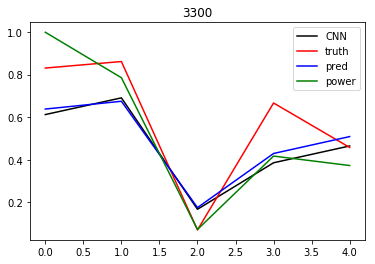

In [85]:
i=randint(nsims_test)
plot(mean(cnn_pred[i],axis=0),c="k",label="CNN")
plot(p_test[i,0],c="r",label="truth")
plot(test_pred[i],c="b",label="pred")
plot(mean(abs(fft.rfft(x_test[i]))**2,axis=0),c="g",label="power")
legend()
title(i)

In [86]:
mean((p_test[:,0]-mean(cnn_pred,axis=1))**2)

0.031235925506093293

24833.0 25053.0


(0.031235925506093293, 0.020833333333333332)

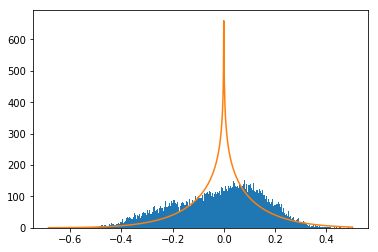

In [88]:
count,bins,n=hist((mean(cnn_pred,axis=1)-p_test[:,0]).flatten(),bins=1000)
print(sum(count[:(where(bins>0)[0][0]-1)]),sum(count[where(bins>0)[0][0]:]))
plot((bins[:-1]+bins[1:])/2,[quad(err_prob,bins[i],bins[i+1])[0]*size*nsims_test for i in range(1000)])
mean((p_test[:,0]-mean(cnn_pred,axis=1))**2),2/3/sample_size

In [6]:
def field_from_spectrum(ps,boxsize=128,n=1):
    f=randn(n,boxsize,boxsize)*exp(2j*pi*rand(n,boxsize,boxsize))
    for i in range(boxsize//2+1):
        for j in range(boxsize):
            f[:,i,j]=f[:,i,j]*ps((i**2+min(j,boxsize-j)**2)**.5)**.5
    f[:,0,0]=abs(f[:,0,0])*(randint(2,size=n)*2-1)
    if not boxsize%2:
        f[:,0,boxsize//2]=abs(f[:,0,boxsize//2])*(randint(2,size=n)*2-1)
        f[:,boxsize//2,0]=abs(f[:,boxsize//2,0])*(randint(2,size=n)*2-1)
        f[:,boxsize//2,boxsize//2]=abs(f[:,boxsize//2,boxsize//2])*(randint(2,size=n)*2-1)
        for i in range(boxsize//2+1,boxsize):
            f[:,boxsize//2,i]=conj(f[:,boxsize//2,boxsize-i])
    for j in range(boxsize//2+1,boxsize):
        f[:,0,j]=conj(f[:,0,boxsize-j])
        f[:,j,0]=conj(f[:,boxsize-j,0])
        for i in range(1,boxsize):
            f[:,j,i]=conj(f[:,boxsize-j,boxsize-i])
    return real(fft.fft2(f))

In [1]:
figure(figsize=(12,12))
imshow(field_from_spectrum(lambda x: (x+.5)**-5,boxsize=1024)[0])
colorbar()

NameError: name 'figure' is not defined

In [7]:
# box size
size=128

# Define input function for estimator
batch_size = 32

#Number of samples to learn each power spectrum
#sample_size=32

# Number of training and testing simulations
nsims_train = 10000
nsims_test = 1000

# Parametrise ps
def pps(par):
    return lambda x: (x+.5)**-par

# sample parameters uniformly from [0,5]
p_train = 5*rand(nsims_train,1)
p_test = 5*rand(nsims_test,1)

x_train = array([field_from_spectrum(pps(p[0]),boxsize=size)[0] for p in p_train])
x_test = array([field_from_spectrum(pps(p[0]),boxsize=size)[0] for p in p_test])

normalised_p_train = (p_train-2.5)/2.5
normalised_p_test = (p_test-2.5)/2.5

def _epoch_input_fn():
    """Serving input fn for training data"""
    dataset = tf.data.Dataset.from_tensor_slices((x_train.astype('float32'), normalised_p_train.astype('float32')))
    dataset = dataset.repeat().shuffle(1000).batch(batch_size)
    return dataset

def _testing_input_fn():
    """Serving input fn for testing data"""
    dataset = tf.data.Dataset.from_tensor_slices((x_test.astype('float32'), normalised_p_test.astype('float32')))
    dataset = dataset.batch(batch_size)
    return dataset

In [171]:
#from vanessa
from scipy.stats import binned_statistic

def compute_2Dpower(x,BoxSize,Nmesh,kmin=None, dk=None):
    Nx = Nmesh[0]
    Ny = Nmesh[1]
    Lx = BoxSize[0]
    Ly = BoxSize[1]
    kx = np.fft.fftfreq(Nx,d=1./(2.*np.pi*Nx/Lx))
    ky = np.fft.fftfreq(Ny,d=1./(2.*np.pi*Ny/Ly))
    kx,ky = np.meshgrid(kx,ky)
    k = np.sqrt(kx**2+ky**2).flatten()
    myfft = numpy.fft.fftn(x)/Nx/Ny

    mypow = (myfft.real**2+myfft.imag**2).flatten()*Lx*Ly
    
    ii=np.argsort(k)
    k=k[ii]
    mypow=mypow[ii]
    if dk is None:
        dk = 2 * np.pi / min((Lx,Ly))*2
    if kmin is None:
        kmin = dk
    kedges = numpy.arange(kmin, numpy.pi*min(Nx,Ny)/max(Lx,Ly) + dk/2, dk)
    binpow, a, b =binned_statistic(k, mypow, statistic='mean', bins=kedges, range=None)
    binerr, a, b =binned_statistic(k, mypow**2, statistic='mean', bins=kedges, range=None) #std works, too
    N, a, b = binned_statistic(k, mypow, statistic='count', bins=kedges, range=None)
    bink,a ,b  =binned_statistic(k, k, statistic='mean', bins=kedges, range=None)
    binerr = np.sqrt((binerr-binpow**2)/N)
    return bink, binpow, binerr, N

def power_spectrum(x):
    size=x.shape[-1]
    kx,ky=arange(size),arange(size)
    kx,ky=minimum(kx,size-kx),minimum(kx,size-kx)
    kx,ky=meshgrid(kx,ky)
    k=sqrt(kx**2+ky**2).flatten()
    p=(abs(fft.ifft2(x))**2).flatten()
    avg,edges,f= binned_statistic(k,p)
    err,edges,f= binned_statistic(k,p**2)
    count,edges,f=binned_statistic(k,p,statistic="count")
    return (edges[:-1]+edges[1:])/2,avg,sqrt((err-avg**2)/count),count

/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use

8709 [3.89539134] [ 1.13137085  3.39411255  5.65685425  7.91959595 10.18233765 12.44507935
 14.70782105 16.97056275 19.23330445 21.49604615] [1.56209063e-01 4.11352008e-03 8.21856472e-04 2.48268508e-04
 8.99945332e-05 4.40911311e-05 2.70128241e-05 1.26918954e-05
 1.18640540e-05 6.65957330e-06] [ 21.  48.  76. 108. 148. 176. 216. 142.  64.  25.]
983 [3.15025617] [ 1.13137085  3.39411255  5.65685425  7.91959595 10.18233765 12.44507935
 14.70782105 16.97056275 19.23330445 21.49604615] [1.20221717e+00 1.00539465e-02 3.70483025e-03 1.58065745e-03
 7.39450957e-04 2.59180427e-04 1.45298477e-04 1.36411474e-04
 7.88450244e-05 3.80053298e-05] [ 21.  48.  76. 108. 148. 176. 216. 142.  64.  25.]
2430 [1.0598641] [ 1.13137085  3.39411255  5.65685425  7.91959595 10.18233765 12.44507935
 14.70782105 16.97056275 19.23330445 21.49604615] [0.11299124 0.17386203 0.14895846 0.08140057 0.08395578 0.05727858
 0.05288941 0.05332311 0.04964899 0.03200082] [ 21.  48.  76. 108. 148. 176. 216. 142.  64.  25.]
99

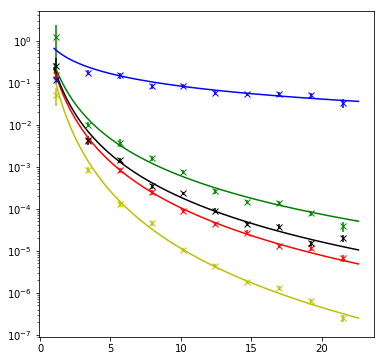

In [173]:
col=["r","g","b","k","y"]
for j in range(5):
    i=randint(nsims_train)
    #imshow(x_train[i])
    k,kpow,kerr,kcount=power_spectrum(x_train[i])
    print(i,p_train[i],k,kpow,kcount)
    errorbar(k,kpow,yerr=kerr,marker="x",ls="",c=col[j])
    x=linspace(1,size/2**.5,100)
    semilogy(x,(.5+x)**-p_train[i],c=col[j])

In [247]:
class PSEp_2d(tf.estimator.Estimator):

    def __init__(self,
               feature_columns,
               label_columns,
               optimizer=tf.train.AdamOptimizer,
               activation_fn=tf.nn.relu,
               normalizer_fn=tf.contrib.layers.batch_norm,
               dropout=None,
               model_dir=None,
               config=None):
        """Initializes a PSE_1d_v1 instance.
        """

        def _model_fn(features, labels, mode):
            training=mode == tf.estimator.ModeKeys.TRAIN
            # Builds the neural network
            conv = tf.layers.conv2d(tf.reshape(features,(-1,32,32,1)), 4, 3, activation=tf.nn.leaky_relu)
            pool = tf.layers.max_pooling2d(conv, 3,2)
            conv = tf.layers.conv2d(pool, 16, 3, activation=tf.nn.leaky_relu)
            pool = tf.layers.max_pooling2d(conv, 3,2)
            conv = tf.layers.conv2d(pool, 64, 3, activation=tf.nn.leaky_relu)
            pool = tf.reshape(tf.layers.max_pooling2d(conv, 3,2),(-1,64))
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(pool,rate=0.2,training=training),32,activation_fn=tf.nn.tanh)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),16,activation_fn=tf.nn.tanh)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),8,activation_fn=tf.nn.tanh)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),4,activation_fn=tf.nn.tanh)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),2,activation_fn=tf.nn.tanh)
            predictions = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),1,activation_fn=tf.nn.tanh)

            train_op = None
            eval_metric_ops = None
            
            # Define optimizer
            if mode == tf.estimator.ModeKeys.PREDICT:
                return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
            
            loss=tf.losses.mean_squared_error(predictions,labels)
            
            if training:
                update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                with tf.control_dependencies(update_ops):
                    train_op = optimizer(learning_rate=0.0002).minimize(loss=loss,
                                                global_step=tf.train.get_global_step())
                tf.summary.scalar('loss', loss)
            elif mode == tf.estimator.ModeKeys.EVAL:
                eval_metric_ops = { "loss": loss}

            return tf.estimator.EstimatorSpec(mode=mode,
                                              predictions=predictions,
                                              loss=loss,
                                              train_op=train_op,
                                              eval_metric_ops=eval_metric_ops)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)

In [248]:
model = PSEp_2d(['x'], ['p'], model_dir='models/pse2_model2')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/pse2_model2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aacea73e898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [233]:
model.train(_epoch_input_fn,max_steps=30000)

INFO:tensorflow:Skipping training since max_steps has already saved.


In [12]:
mean(p_train),2.5,std(p_train),2.5/sqrt(3),std(normalised_p_train),1/sqrt(3)

(2.5283418932549266,
 2.5,
 1.4434351263746075,
 1.4433756729740645,
 0.577374050549843,
 0.5773502691896258)

In [1]:
pred = model.predict(_testing_input_fn)
cnn_pred=zeros(nsims_test)
for i in range(nsims_test):
    cnn_pred[i]=(next(pred)[0]+1)*2.5
mu,sig=mean(cnn_pred-p_test[:,0]),std(cnn_pred-p_test[:,0])
count,edges,patches=hist((cnn_pred-p_test[:,0]).flatten(),bins=30)
x=linspace(edges[0],edges[-1],1000)
plot(x,nsims_test*exp(-(x-mu)**2/sig**2/2)/(2*pi)**.5/sig*(edges[1]-edges[0]))
print(mu,sig**2)

NameError: name 'model' is not defined

/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


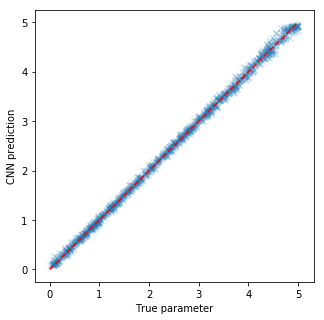

In [193]:
figure(figsize=(5,5))
plot(linspace(0,5,100),linspace(0,5,100),c="r",ls="--")
scatter(p_test,cnn_pred,alpha=0.2,marker="x")
xlabel("True parameter")
ylabel("CNN prediction")
axes().set_aspect('equal', 'datalim')

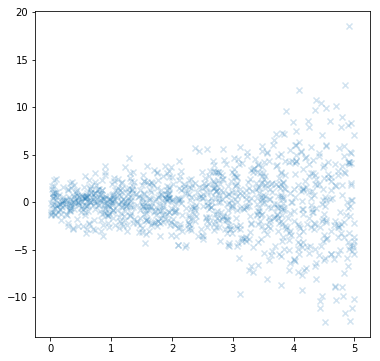

In [114]:
scatter(p_test,mean(x_test,axis=(1,2)),alpha=0.2,marker="x")

#### Questions

1. Why so slow?
2. Why keras faster than custom?
3. Can see kernels?
4. How to turn off/customise output in training?
5. What batch size to use? Seems to keep getting better with larger batches...

#### Options for normalisation of power spectrum

1. Normalise each image, or make a bunch of sims for each parameter value and use those to estimate ps?
2. Parametrise ps, do best-fit?
3. What kind of binning to use?

In [291]:
def get_flt_k_f(x):
    size=x.shape[-1]
    kx,ky=arange(size),arange(size)
    kx,ky=minimum(kx,size-kx),minimum(kx,size-kx)
    kx,ky=meshgrid(kx,ky)
    k=sqrt(kx**2+ky**2).flatten()
    fk=fft.ifft2(x).flatten()
    return k,fk

def norm_10_bins(x):
    size=x.shape[-1]
    k,fk=get_flt_k_f(x)
    p=abs(fk)**2
    avg,edges,binnum= binned_statistic(k,p)
    #print(avg,edges,k[:10],binnum[:10])
    for i in range(size**2):
        fk[i]=fk[i]/avg[binnum[i]-1]**.5
    fk=fk.reshape((size,size))
    return real(fft.fft2(fk))

def norm_func(x,fn):
    size=x.shape[-1]
    k,fk=get_flt_k_f(x)
    p=array([fn(kk) for kk in k])
    fk=fk/p**.5
    return real(fft.fft2(fk.reshape((size,size))))

def bin_by_count(k,n):
    ss={}
    for i in range(len(k)):
        if k[i] in ss.keys():
            ss[k[i]].append(i)
        else:
            ss[k[i]]=[i]
    ks=sorted(ss)
    lens=[len(ss[kk]) for kk in ks]
    indices=[]
    currind=[]
    edges=[ks[0]]
    for kk in ks:
        currind = currind + ss[kk]
        if len(currind) >= n:
            edges.append(kk)
            indices.append(currind)
            currind=[]
    indices[-1]=indices[-1]+currind
    edges[-1]=ks[-1]
    return indices,edges

def norm_binning_by_count(x,count=20):
    size=x.shape[-1]
    k,fk=get_flt_k_f(x)
    p=abs(fk)**2
    indices,edges=bin_by_count(k,count)
    binned_k=[[k[ices] for ices in ind] for ind in indices]
    binned_p=[[p[ices] for ices in ind] for ind in indices]
    mean_p=[mean(pp) for pp in binned_p]
    for i,ind in enumerate(indices):
        for ices in ind:
            fk[ices]=fk[ices]/mean_p[i]**.5
    return real(fft.fft2(fk.reshape((size,size))))

/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


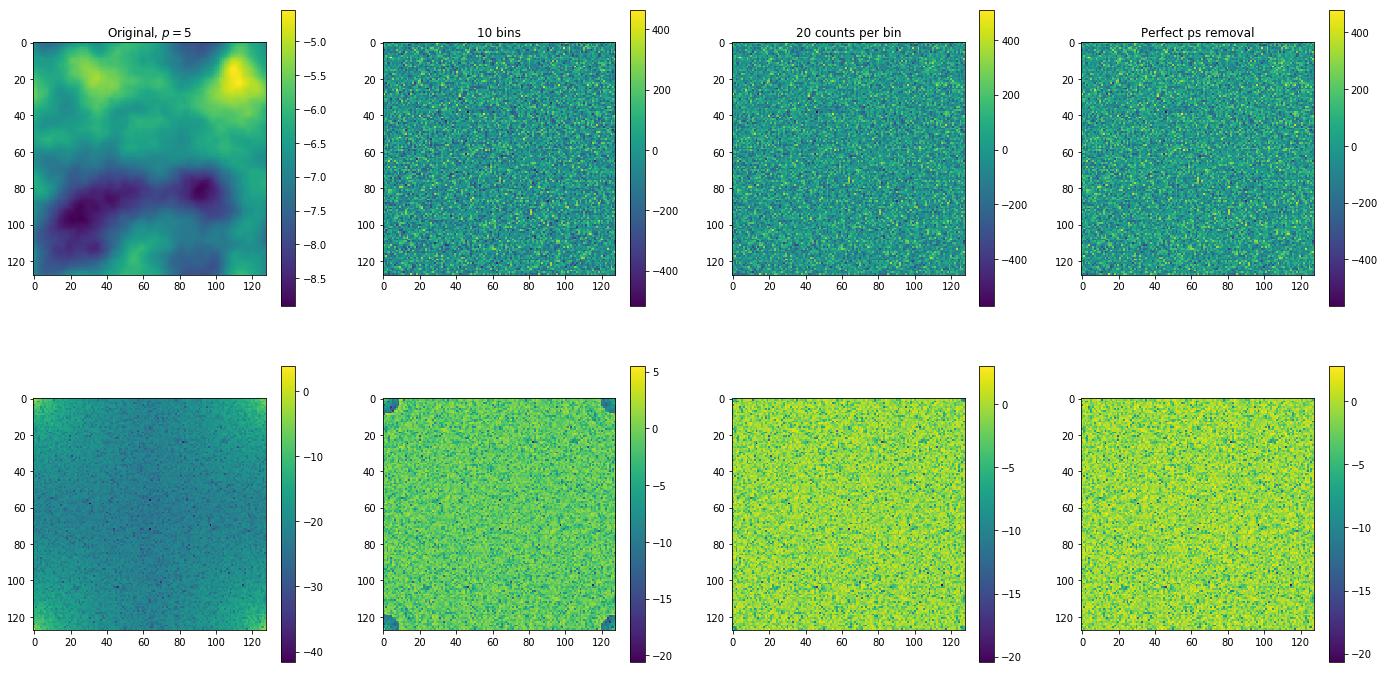

In [344]:
figure(figsize=(24,12))
par=5
fn=pps(par)
subplot(241)
title("Original, $p="+str(par)+"$")
x=field_from_spectrum(fn,boxsize=128)[0]
imshow(x)
colorbar()
subplot(242)
title("10 bins")
imshow(norm_10_bins(x))
colorbar()
subplot(243)
title("20 counts per bin")
imshow(norm_binning_by_count(x))
colorbar()
subplot(244)
title("Perfect ps removal")
imshow(norm_func(x,fn))
colorbar()
subplot(245)
imshow(log(abs(fft.ifft2(x))**2))
colorbar()
subplot(246)
imshow(log(abs(fft.ifft2(norm_10_bins(x)))**2))
colorbar()
subplot(247)
imshow(log(abs(fft.ifft2(norm_binning_by_count(x)))**2))
colorbar()
subplot(248)
imshow(log(abs(fft.ifft2(norm_func(x,fn)))**2))
colorbar()

In [ ]:
norm10_x_train = array([norm_10_bins(x) for x in x_train])
norm10_x_test = array([norm_10_bins(x) for x in x_test])

In [263]:
def _norm10_input_fn():
    """Serving input fn for training data"""
    dataset = tf.data.Dataset.from_tensor_slices((norm10_x_train.astype('float32'), normalised_p_train.astype('float32')))
    dataset = dataset.repeat().shuffle(1000).batch(batch_size)
    return dataset

def _norm10_train_fn():
    """Serving input fn for training data"""
    dataset = tf.data.Dataset.from_tensor_slices((norm10_x_train.astype('float32'), normalised_p_train.astype('float32')))
    dataset = dataset.batch(batch_size)
    return dataset

def _norm10_testing_fn():
    """Serving input fn for training data"""
    dataset = tf.data.Dataset.from_tensor_slices((norm10_x_test.astype('float32'), normalised_p_test.astype('float32')))
    dataset = dataset.batch(batch_size)
    return dataset

In [251]:
norm_model = PSEp_2d(['x'], ['p'], model_dir='models/pse2_norm_model1')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/pse2_norm_model1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aacea73e550>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [269]:
norm_model.train(_norm10_input_fn,max_steps=30000)

INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/pse2_norm_model1/model.ckpt-30000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
1.2237815507632752
1.2234963338556124


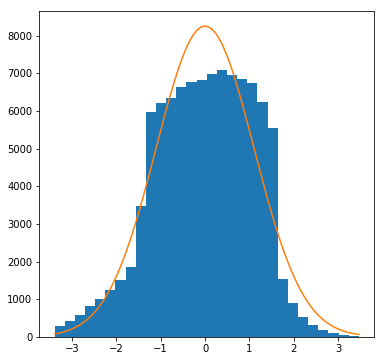

In [270]:
pred = norm_model.predict(_norm10_train_fn)
cnn_pred=zeros(nsims_train)
for i in range(nsims_train):
    cnn_pred[i]=(next(pred)[0]+1)*2.5
print(mean((cnn_pred-p_train[:,0])**2))
sig=std(cnn_pred-p_train[:,0])
count,edges,patches=hist((cnn_pred-p_train[:,0]).flatten(),bins=30)
x=linspace(edges[0],edges[-1],1000)
plot(x,nsims_train*exp(-x**2/sig**2/2)/(2*pi)**.5/sig*(edges[1]-edges[0]))
print(sig**2)

/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


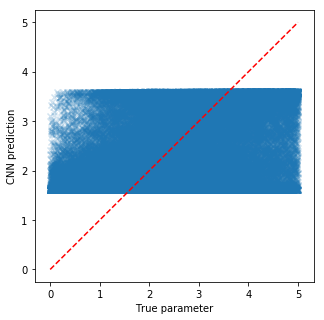

In [271]:
figure(figsize=(5,5))
plot(linspace(0,5,100),linspace(0,5,100),c="r",ls="--")
scatter(p_train[:,0],cnn_pred,alpha=0.2,marker="x")
xlabel("True parameter")
ylabel("CNN prediction")
axes().set_aspect('equal', 'datalim')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/pse2_norm_model1/model.ckpt-30000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
1.2565429785232383
1.2563578407455245


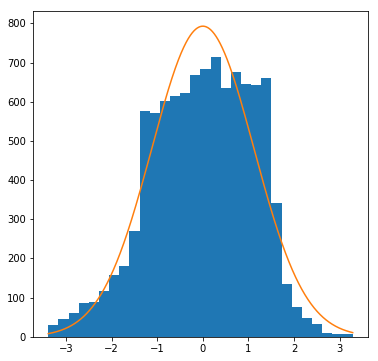

In [272]:
pred = norm_model.predict(_norm10_testing_fn)
cnn_pred=zeros(nsims_test)
for i in range(nsims_test):
    cnn_pred[i]=(next(pred)[0]+1)*2.5
print(mean((cnn_pred-p_test[:,0])**2))
sig=std(cnn_pred-p_test[:,0])
count,edges,patches=hist((cnn_pred-p_test[:,0]).flatten(),bins=30)
x=linspace(edges[0],edges[-1],1000)
plot(x,nsims_test*exp(-x**2/sig**2/2)/(2*pi)**.5/sig*(edges[1]-edges[0]))
print(sig**2)

/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


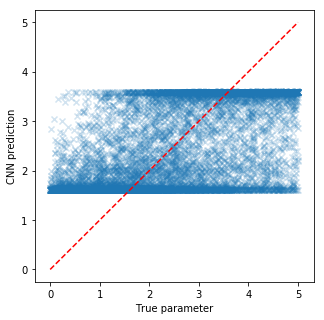

In [273]:
figure(figsize=(5,5))
plot(linspace(0,5,100),linspace(0,5,100),c="r",ls="--")
scatter(p_test,cnn_pred,alpha=0.2,marker="x")
xlabel("True parameter")
ylabel("CNN prediction")
axes().set_aspect('equal', 'datalim')

In [46]:
class PSEp_2d_128(tf.estimator.Estimator):

    def __init__(self,
               feature_columns,
               label_columns,
               optimizer=tf.train.AdamOptimizer,
               activation_fn=tf.nn.relu,
               normalizer_fn=tf.contrib.layers.batch_norm,
               dropout=None,
               model_dir=None,
               config=None):
        """Initializes a PSE_1d_v1 instance.
        """

        def _model_fn(features, labels, mode):
            training=mode == tf.estimator.ModeKeys.TRAIN
            # Builds the neural network
            conv = tf.layers.conv2d(tf.reshape(features,(-1,128,128,1)), 4, 3, activation=tf.nn.leaky_relu)
            pool = tf.layers.max_pooling2d(conv, 3,3)
            conv = tf.layers.conv2d(pool, 16, 3, activation=tf.nn.leaky_relu)
            pool = tf.layers.max_pooling2d(conv, 3,3)
            conv = tf.layers.conv2d(pool, 64, 3, activation=tf.nn.leaky_relu)
            pool = tf.layers.max_pooling2d(conv, 3,3)
            conv = tf.layers.conv2d(pool, 128, 3, activation=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(tf.reshape(conv,(-1,128)),rate=0.2,training=training),128,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),32,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),8,activation_fn=tf.nn.tanh)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),4,activation_fn=tf.nn.tanh)
            predictions = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),1,activation_fn=tf.nn.tanh)

            train_op = None
            eval_metric_ops = None
            
            # Define optimizer
            if mode == tf.estimator.ModeKeys.PREDICT:
                return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
            
            loss=tf.losses.mean_squared_error(predictions,labels)
            
            if training:
                update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                with tf.control_dependencies(update_ops):
                    train_op = optimizer(learning_rate=0.0002).minimize(loss=loss,
                                                global_step=tf.train.get_global_step())
                tf.summary.scalar('loss', loss)
            elif mode == tf.estimator.ModeKeys.EVAL:
                eval_metric_ops = { "loss": loss}

            return tf.estimator.EstimatorSpec(mode=mode,
                                              predictions=predictions,
                                              loss=loss,
                                              train_op=train_op,
                                              eval_metric_ops=eval_metric_ops)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)

In [47]:
model = PSEp_2d_128(['x'], ['p'], model_dir='/global/cscratch1/sd/avirukt/models/pse2_128_model8')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/global/cscratch1/sd/avirukt/models/pse2_128_model8', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aab96dcdef0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [48]:
model.train(_epoch_input_fn,max_steps=10000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /global/cscratch1/sd/avirukt/models/pse2_128_model8/model.ckpt.
INFO:tensorflow:loss = 0.66733944, step = 1
INFO:tensorflow:global_step/sec: 22.0061
INFO:tensorflow:loss = 0.12547697, step = 101 (4.547 sec)
INFO:tensorflow:global_step/sec: 22.6716
INFO:tensorflow:loss = 0.056515805, step = 201 (4.410 sec)
INFO:tensorflow:global_step/sec: 23.724
INFO:tensorflow:loss = 0.08194602, step = 301 (4.214 sec)
INFO:tensorflow:global_step/sec: 24.231
INFO:tensorflow:loss = 0.032561302, step = 401 (4.127 sec)
INFO:tensorflow:global_step/sec: 23.8398
INFO:tensorflow:loss = 0.05716408, step = 501 (4.196 sec)
INFO:tensorflow:global_step/sec: 23.9163
INFO:tensorflow:loss = 0.026310895, step = 601 (4.180 sec)
INFO:tensorflo

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/pse2_128_model8/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0.016515707246594766


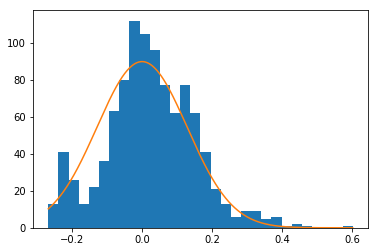

In [49]:
pred = model.predict(_testing_input_fn)
cnn_pred=zeros(nsims_test)
for i in range(nsims_test):
    cnn_pred[i]=(next(pred)[0]+1)*2.5
sig=std(cnn_pred-p_test[:,0])
count,edges,patches=hist((cnn_pred-p_test[:,0]).flatten(),bins=30)
x=linspace(edges[0],edges[-1],1000)
plot(x,nsims_test*exp(-x**2/sig**2/2)/(2*pi)**.5/sig*(edges[1]-edges[0]))
print(sig**2)

/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


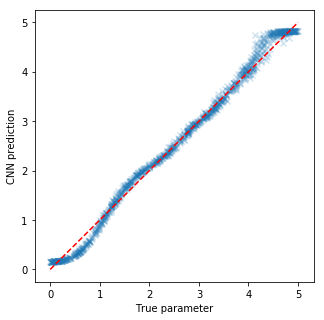

In [50]:
figure(figsize=(5,5))
plot(linspace(0,5,100),linspace(0,5,100),c="r",ls="--")
scatter(p_test,cnn_pred,alpha=0.2,marker="x")
xlabel("True parameter")
ylabel("CNN prediction")
axes().set_aspect('equal', 'datalim')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/pse2_128_model1/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
1.983472548792784


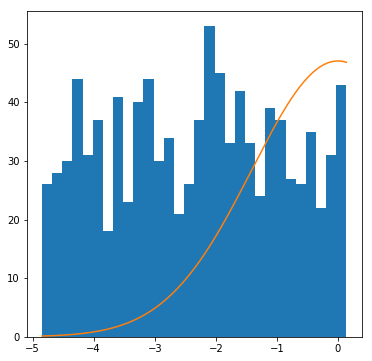

In [332]:
pred = model.predict(_norm10_testing_fn)
cnn_pred=zeros(nsims_test)
for i in range(nsims_test):
    cnn_pred[i]=(next(pred)[0]+1)*2.5
sig=std(cnn_pred-p_test[:,0])
count,edges,patches=hist((cnn_pred-p_test[:,0]).flatten(),bins=30)
x=linspace(edges[0],edges[-1],1000)
plot(x,nsims_test*exp(-x**2/sig**2/2)/(2*pi)**.5/sig*(edges[1]-edges[0]))
print(sig**2)

/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


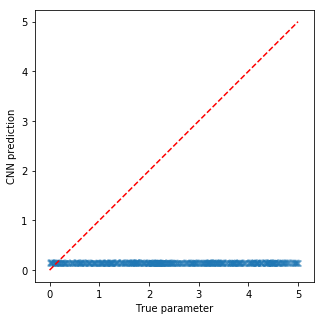

In [333]:
figure(figsize=(5,5))
plot(linspace(0,5,100),linspace(0,5,100),c="r",ls="--")
scatter(p_test,cnn_pred,alpha=0.2,marker="x")
xlabel("True parameter")
ylabel("CNN prediction")
axes().set_aspect('equal', 'datalim')

In [330]:
norm_model = PSEp_2d_128(['x'], ['p'], model_dir='models/pse2_norm_128_model1')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/pse2_norm_128_model1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aad597e4fd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
norm_model.train(_norm10_input_fn,max_steps=60000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/pse2_norm_128_model1/model.ckpt-46931
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
1.9833636196633064


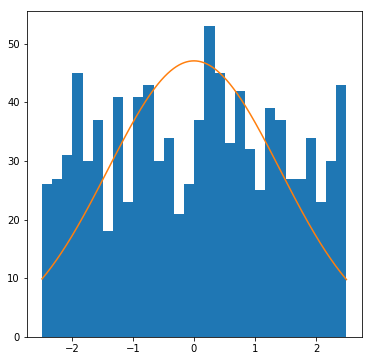

In [336]:
pred = norm_model.predict(_norm10_testing_fn)
cnn_pred=zeros(nsims_test)
for i in range(nsims_test):
    cnn_pred[i]=(next(pred)[0]+1)*2.5
sig=std(cnn_pred-p_test[:,0])
count,edges,patches=hist((cnn_pred-p_test[:,0]).flatten(),bins=30)
x=linspace(edges[0],edges[-1],1000)
plot(x,nsims_test*exp(-x**2/sig**2/2)/(2*pi)**.5/sig*(edges[1]-edges[0]))
print(sig**2)

/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


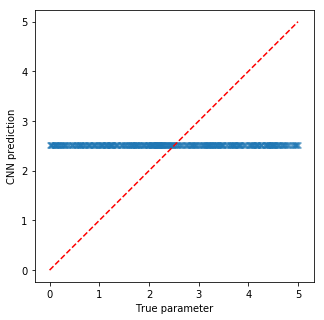

In [337]:
figure(figsize=(5,5))
plot(linspace(0,5,100),linspace(0,5,100),c="r",ls="--")
scatter(p_test,cnn_pred,alpha=0.2,marker="x")
xlabel("True parameter")
ylabel("CNN prediction")
axes().set_aspect('equal', 'datalim')